In [ ]:
#| default_exp gstreamer.valve

# Gstreamer Valve 
> Gstreamer video capture with on/off valve
> This has been superseded by gstreamer.python




https://github.com/jackersson/gst-python-tutorials
https://github.com/jackersson


In [ ]:
#| hide
# skip_showdoc: true to avoid running cells when rendering docs, and skip_exec: true to skip this notebook when running tests. 
# this should be a raw cell 

In [ ]:
#| export
from UAV.imports import *   # TODO why is this relative import on nbdev_export?
from fastcore.utils import *
import gi
import numpy as np
import threading
gi.require_version('Gst', '1.0')
from gi.repository import Gst
import subprocess
import platform

import paho.mqtt.client as mqtt_client

import time

from pathlib import Path
import logging
import UAV.params as params

In [ ]:
#| export
logging.basicConfig(format='%(asctime)-8s,%(msecs)-3d %(levelname)5s [%(filename)10s:%(lineno)3d] %(message)s',
                    datefmt='%H:%M:%S',
                    level=params.LOGGING_LEVEL)  # Todo add this to params
logger = logging.getLogger(params.LOGGING_NAME)

In [ ]:
#| hide
from nbdev.showdoc import *
from fastcore.test import *


### Default parameters
Overide these default parameters for application specific applications.

The code is shown below:

In [ ]:
#| exports

from dataclasses import dataclass

@dataclass
class DefaultParams():
    camera_dev = "CAM-0"
    cameras = {
        "CAM-0": {
            "gst": [
                'videotestsrc pattern=smpte is-live=true ! tee name=t ',
                't. ! queue leaky=2 ! videoconvert ! videorate drop-only=true ! video/x-raw,framerate=10/1,format=(string)BGR ! ',
                '   videoconvert ! appsink name=sink emit-signals=true  sync=false async=false  max-buffers=2 drop=true ',
                't. ! queue leaky=2 ! valve name=myvalve drop=true ! video/x-raw,format=I420,width=640,height=480 ! videoconvert ! x264enc ! rtph264pay ! udpsink host=127.0.0.1 port=5000',
                ],
            "udp": True,
            "host": "127.0.0.1",
            "port": 5000,
        },
        "CAM-1": {
            "gst": [
                'videotestsrc pattern=ball is-live=true ! tee name=t ',
                't. ! queue leaky=2 ! videoconvert ! videorate drop-only=true ! video/x-raw,framerate=10/1,format=(string)BGR ! ',
                '   videoconvert ! appsink name=sink emit-signals=true  sync=false async=false  max-buffers=2 drop=true ',
                't. ! queue leaky=2 ! valve name=myvalve drop=true ! video/x-raw,format=I420,width=640,height=480 ! videoconvert ! x264enc ! rtph264pay ! udpsink host=127.0.0.1 port=5001',
                ],
            "udp": True,
            "host": "127.0.0.1",
            "port": 5001,
        },
        "CAM-2": {
            "gst": [
                'videotestsrc pattern=snow is-live=true ! tee name=t ',
                't. ! queue leaky=2 ! videoconvert ! videorate drop-only=true ! video/x-raw,framerate=10/1,format=(string)BGR ! ',
                '   videoconvert ! appsink name=sink emit-signals=true  sync=false async=false  max-buffers=2 drop=true ',
                't. ! queue leaky=2 ! valve name=myvalve drop=true ! video/x-raw,format=I420,width=640,height=480 ! videoconvert ! x264enc ! rtph264pay ! udpsink host=127.0.0.1 port=5002',
                ],
            "udp": True,
            "host": "127.0.0.1",
            "port": 5002,
        },
        "CAM-3": {
            "gst": [
                'videotestsrc pattern=pinwheel is-live=true ! tee name=t ',
                't. ! queue leaky=2 ! videoconvert ! videorate drop-only=true ! video/x-raw,framerate=10/1,format=(string)BGR ! ',
                '  videoconvert ! appsink name=sink emit-signals=true  sync=false async=false  max-buffers=2 drop=true ',
                't. ! queue leaky=2 ! valve name=myvalve drop=true ! video/x-raw,format=I420,width=640,height=480 ! videoconvert ! x264enc ! rtph264pay ! udpsink host=127.0.0.1 port=5003',
                ],
            "udp": True,
            "host": "127.0.0.1",
            "port": 5003,
            },
    
       }

    # socket address and port
    mqqt_address='127.0.0.1'
    src_port=1234

As an example for camera 0, ```DefaultParams.cameras["CAM-0"]["gst"]``` is a list of gstreamer setup commands.

The default parameters list four gst videotestsrc each with a different pattern. 
The patterns are: 
- smpte,  ball, snow, pinwheel.

The video is split with a tee into two streams 
1.  is streamed via an on / off valve to  udp port 5000.
2. is streamed to an appsink for processing.


In [ ]:
gstcommand = DefaultParams().cameras["CAM-0"]["gst"]
print(gstcommand)

['videotestsrc pattern=smpte is-live=true ! tee name=t ', 't. ! queue leaky=2 ! videoconvert ! videorate drop-only=true ! video/x-raw,framerate=10/1,format=(string)BGR ! ', '   videoconvert ! appsink name=sink emit-signals=true  sync=false async=false  max-buffers=2 drop=true ', 't. ! queue leaky=2 ! valve name=myvalve drop=true ! video/x-raw,format=I420,width=640,height=480 ! videoconvert ! x264enc ! rtph264pay ! udpsink host=127.0.0.1 port=5000']


### Gstreamer Receive Pipeline Class

the class is called with the gst command list and the address and port.
```frame_available``` is a flag that is set when a new frame is available.

In [ ]:
#| exports

# https://github.com/gkralik/python-gst-tutorial/blob/master/basic-tutorial-4.py

class GstStream():
    """"GstStream  class using gstreamer
        Create and start a GStreamer pipe
            gst_pipe = GstStream() 
            The valve is a simple element that drops buffers when the drop property is set to TRUE and lets then through otherwise. 
        """

    def __init__(self, name:str='CAM-0' # camera name
                 , gstcommand:List=['videotestsrc ! autovideosink'] # gst command list
                 , address:str='127.0.0.1'  # udp address
                 , port:int=5000): # udp port
        self.cname = self.__class__.__name__
        Gst.init(None)
        assert isinstance(name, str), "name must be a string"
        self.name = name
        assert isinstance(gstcommand, List), "gstcommand must be a list"
        self.gstcommand = gstcommand
        self.address = address
        self.port = port

        self.latest_frame = self._new_frame = None
        self.start_gst()
        self._thread = threading.Thread(target=self.msg_thread_func, daemon=True)
        self._stop_thread = False
        # self._thread .start()
        logger.info(f"{self.cname} started")

    def start_gst(self):
        """ Start gstreamer pipeline and sink
        """
        if self.gstcommand != []:
            command = ' '.join(self.gstcommand)
        else:
            command = 'videotestsrc ! autovideosink'
            command = "videotestsrc ! tee name=t t. ! queue ! autovideosink " +\
                       " t. ! videoconvert ! video/x-raw,format=(string)BGR ! videoconvert ! " +\
                       " queue ! appsink name=sink emit-signals=true "

        # print (command)
        self.pipeline = Gst.parse_launch(command)
        self.appsink = self.pipeline.get_by_name('sink')
        if self.appsink is None:
            logger.warning(f"{self.cname} Error: appsink is None")
        else:
            self.appsink.connect('new-sample', self.sink_callback)
        
        # appsrc = self.pipeline.get_by_name('source')
        # if appsrc is None:
        #     logger.warning(f"{self.cname} Error: appsrc is None")
        # else:
        #     appsrc.connect('need-data', self.callback)
        #     
        #     
        # try:
        #     self.appsink.connect('new-sample', self.callback)
        # except:
        #     logger.error(f"{self.cname} Error connecting to callback")
        #
        self.pipeline.set_state(Gst.State.PLAYING)
        self.bus = self.pipeline.get_bus() # https://lazka.github.io/pgi-docs/Gst-1.0/classes/Bus.html
        # allow bus to emit messages to main thread
        self.bus.add_signal_watch()
        self.bus.connect("message", self.on_message) # https://lazka.github.io/pgi-docs/GObject-2.0/classes/Object.html#GObject.Object.connect
        
    def on_message(self, bus:Gst.Bus
                   , message: Gst.Message):     
        """Callback function for bus message
                Gstreamer Message Types and how to parse
                https://lazka.github.io/pgi-docs/Gst-1.0/flags.html#Gst.MessageType
        """
        print("on_message")
        t = message.type
        if t == Gst.MessageType.EOS:
            self.pipeline.set_state(Gst.State.NULL)
            logger.info(f"{self.cname} End-Of-Stream reached.")
        elif t == Gst.MessageType.ERROR:
            err, debug = message.parse_error()
            logger.error(f"{self.cname} Error received from element {message.src.get_name()}: {err}")
            logger.error(f"{self.cname} Debugging information: {debug}")
            self.pipeline.set_state(Gst.State.NULL)
        elif t == Gst.MessageType.WARNING:
            err, debug = message.parse_warning()
            logger.warning(f"{self.cname} Warning received from element {message.src.get_name()}: {err}")
            logger.warning(f"{self.cname} Debugging information: {debug}")
        return True
        
    def msg_thread_func(self):   
        "Run thread"
        # Poll for messages on the bus (like EOS or ERROR), and handle them
        while not self._stop_thread:
            message = self.bus.timed_pop_filtered(100*Gst.MSECOND, Gst.MessageType.ANY)
            if message is None:
                continue
    
            if message.type == Gst.MessageType.EOS:
                logger.info("End-Of-Stream reached.")
                break
            elif message.type == Gst.MessageType.ERROR:
                err, debug = message.parse_error()
                logger.error(f"{self.cname} Error received from element {message.src.get_name()}: {err}")
                logger.error(f"{self.cname} Debugging information: {debug}")
                break
        # # Cleanup 
        # logger.info(f"{self.cname} Stopping pipeline")
        # self.pipeline.set_state(Gst.State.NULL)
        
    @staticmethod
    def gst_to_opencv(sample):
        "Transform byte array into np array"
        buf = sample.get_buffer()
        caps_structure = sample.get_caps().get_structure(0)
        array = np.ndarray(
            ( caps_structure.get_value('height'),caps_structure.get_value('width'), 3),
            buffer=buf.extract_dup(0, buf.get_size()), dtype=np.uint8)
        return array

    def frame(self):
        """ Get Frame
        Returns:
            np.ndarray: latest retrieved image frame
        """
        if self.frame_available():
            self.latest_frame = self._new_frame
            # reset to indicate latest frame has been 'consumed'
            self._new_frame = None
        return self.latest_frame

    def frame_available(self, 
                             timeout=2  # timeout in seconds
                             )->bool:   # true if a new frame is available within timeout    
        """Wait for a new frame to be available"""
        elapsetime = 0
        while self._new_frame is None:
            time.sleep(0.01)
            elapsetime += 0.01
            if elapsetime > timeout:
                return False
        return True
    
            
    def sink_callback(self, sink):
        sample = sink.emit('pull-sample')
        # if not self.pause:
        self._new_frame = self.gst_to_opencv(sample)

        return Gst.FlowReturn.OK
    
    # def need_data(self, appsrc, length):
    #     """ Push data into the appsrc when needed
    #     """
    #     if self._new_frame is None:
    #         return
    #     data = self._new_frame.tostring()
    #     appsrc.emit("push-buffer", Gst.Buffer.new_wrapped(data))
    #     self._new_frame = None
        
        # data = self.frame.tobytes()
        # buf = Gst.Buffer.new_allocate(None, len(data), None)
        # buf.fill(0, data)
        # buf.duration = self.duration
        # timestamp = self.number_frames * self.duration
        # buf.pts = buf.dts = int(timestamp)
        # buf.offset = timestamp
        # 
        # retval = src.emit('push-buffer', buf)
        # info = f"frame {self.number_frames}, duration {self.duration / Gst.SECOND}, code {codes[0]} s"
        # # print(info)
        # if retval != Gst.FlowReturn.OK:
        #     print(retval)
        
    def close(self):
        """Close gstreamer pipeline
        see https://github.com/gkralik/python-gst-tutorial/blob/master/basic-tutorial-1.py
        """
        self.pipeline.send_event(Gst.Event.new_eos())   # Todo does not seem to stop pipeline
        self.pipeline.set_state(Gst.State.NULL)
        self._stop_thread = True
        # self._thread.join()
        logger.info(f"{self.cname}  closed")

        
    def __enter__(self):
        """with context manager"""

        return self  # This value is assigned to the variable after 'as' in the 'with' statement
    
    def __exit__(self, exc_type, exc_value, traceback):
        """with context manager"""
        self.close()
        # If an exception occurred, exc_type, exc_value, and traceback will be provided
        # Returning False (or None) will propagate the exception
        # Returning True will suppress it
        return False
    
# with GstStream("CAM-0", gstcommand) as gs:
#     gs.cls()

In [ ]:
from UAV.utils.display import show_image
DEFAULT_PIPELINE = "videotestsrc num-buffers=10 ! autovideosink"
gstcommand = DefaultParams().cameras["CAM-0"]["gst"]
with GstStream("CAM-0", [DEFAULT_PIPELINE]) as gststream:
    # gststream.pipeline.set_state(-1000)/
    gststream.pipeline.set_state(Gst.State.PLAYING)
    avail = gststream.frame_available()
    print(f"frame is avail = {avail}")
    # or 
    test_eq(gststream.frame_available(), True)
    ax = show_image(gststream.frame(), figsize=(3,3), rgb2bgr=True)

18:40:39,684 WARNING [1229846566.py: 47] GstStream Error: appsink is None
18:40:39,751  INFO [1229846566.py: 30] GstStream started


frame is avail = False


18:40:43,831  INFO [1229846566.py:183] GstStream  closed


AssertionError: ==:
False
True

To run the above pipeline 
```gst_pipeline = GstStream()```

To close pipeline, run 
```gst_pipeline.pipeline.close()```

In [ ]:
show_doc(GstStream.frame_available)

18:40:27,66   INFO [1229846566.py: 30] GstStream started
18:40:27,88   INFO [1229846566.py:183] GstStream  closed


frame is avail = True


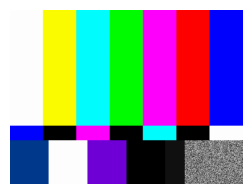

In [ ]:
#|eval: true
from UAV.utils.display import show_image
gstcommand = DefaultParams().cameras["CAM-0"]["gst"]
with GstStream("CAM-0", gstcommand) as gststream:
    avail = gststream.frame_available()
    print(f"frame is avail = {avail}")
    # or 
    test_eq(gststream.frame_available(), True)
    ax = show_image(gststream.frame(), figsize=(3,3), rgb2bgr=True)

#### Valve gives the ability to pause the video stream
The valve is a simple element that drops buffers when the drop property is set to TRUE and lets then through otherwise. 

In [ ]:
#| export
@patch
def set_valve_state(self:GstStream
                    , valvename: str  # name of valve element
                    , drop_state: bool  # True = drop frames
                    ):
    """Set the state of a valve element
    The valve is a simple element that drops buffers when the drop property is set to TRUE and lets then through otherwise. """
    valve = self.pipeline.get_by_name(valvename)
    valve.set_property("drop", drop_state)
    new_drop_state = valve.get_property("drop")
    logger.info(f"{self.name}: new drop state: {new_drop_state}")


In [ ]:
#| export
@patch
def get_valve_state(self:GstStream
                    , valvename: str  # name of valve element
                    ):
    "Get the state of a valve element"

    valve = self.pipeline.get_by_name(valvename)
    return valve.get_property("drop")


Test the valve

In [ ]:
#|eval: true
gstcommand = DefaultParams().cameras["CAM-0"]["gst"]
with GstStream("CAM-0", gstcommand) as gststream:
    avail = gststream.frame_available()
    print(f"frame is avail = {avail}")
    gststream.set_valve_state("myvalve", True)
    test_eq(gststream.get_valve_state("myvalve"), True) 
    gststream.set_valve_state("myvalve", False)
    test_eq(gststream.get_valve_state("myvalve"), False)



#### Ping IP address

In [ ]:
#| export
def ping_ip(ip_address:str # IP address to ping
            )->bool :  # returns True if IP address is in use
    "Ping an IP address to see if it is in use"
    if platform.system().lower() == "windows":
        status = subprocess.call(
            ['ping', '-q', '-n', '1', '-W', '1', ip_address],
            stdout=subprocess.DEVNULL)
    else:
        status = subprocess.call(
            ['ping', '-q', '-c', '1', '-W', '1', ip_address],
            stdout=subprocess.DEVNULL)
        
    if status == 0:
        logger.debug(f"Ping: Found {ip_address}")
        return True
    else:
        logger.debug(f"Ping: cant find {ip_address}")
        return False

In [ ]:
#|eval: false
show_doc(ping_ip)

Test ping IP

In [ ]:
test_eq(ping_ip("127.0.0.1"), True)
test_eq(ping_ip("1.2.3.4"), False)

### MQTT
MQTT is used to control the valve state.
MQTT is a lightweight publish-subscribe messaging protocol that is used on top of TCP/IP. It needs a broker to work. The broker is responsible for distributing messages to interested clients based on the topic of a message. The broker is also responsible for authenticating clients and authorizing them to publish and subscribe to various topics. The broker is the central hub for all communications in the system.
#### install MQTT broker 
```sh
sudo apt-add-repository ppa:mosquitto-dev/mosquitto-ppa.
sudo apt-get update.
sudo apt-get install mosquitto.
sudo apt-get install mosquitto-clients.
sudo apt clean.
```

#### mosquitto-clients
is a set of command line tools that can be used for publishing and subscribing messages to MQTT broker.
For example from second terminal run the following to publish a message to the topic STREAM-CAMERA. This will be received by the mqtt client and the valve state will be set accordingly.
```sh
  mosquitto_pub -m "CAM-0" -t "STREAM-CAMERA"
  mosquitto_pub -m "CAM-1" -t "STREAM-CAMERA"
```

In [ ]:
#| export
class Mqtt:
    "Class to control a gst valve via MQTT"
    def __init__(self, camera:str  # name of camera
                 , video:GstStream  # video object
                 , valve_name:str="myvalve"  # name of valve element
                 , addr:str="127.0.0.1"  # IP address of MQTT broker
                 ):
        self.cname = self.__class__.__name__
        self.camera = camera
        self.video = video
        self.valve_name = valve_name
        self.client = mqtt_client.Client(self.camera)
        self.msg = None

        if ping_ip(addr):
            # logger.info(f"Ping: Connecting to {addr}")
            self.client.connect(addr)
        else:
            # logger.info("Ping: Connecting to 127.0.0.1")
            self.client.connect("127.0.0.1")

        self.client.loop_start()
        
        self.connected = False
        self.client.on_message = self.on_mqtt_message
        self.client.on_connect = self.on_connect


    def on_mqtt_message(self, client:mqtt_client.Client # mqtt client
                        , userdata # user data
                        , message:mqtt_client.MQTTMessage # message
                        ):
        """Callback function for mqtt_client message
            Sets the valve state to True or False depending on the message payload"""
        self.msg = str(message.payload.decode("utf-8"))
        logger.info(f"{self.cname} Received message: {self.msg}" )
        if self.video is not None:
            try:
                if self.msg == self.camera:
                    self.video.set_valve_state(self.valve_name, False)
                else:
                    self.video.set_valve_state(self.valve_name, True)
            except Exception as e:
                logger.error(f"{self.cname}: Not able to set valve state: {e}")   # todo - log this error and fix it
    
    # The callback for when the client receives a CONNACK response from the server.
    def on_connect(self, client, userdata, flags, rc):
        """The callback for when the client receives a CONNACK response from the server."""
        logger.info(f"{self.cname} connected with result code {str(rc)}")
        self.client.subscribe("STREAM-CAMERA")
        self.connected = True
        
    def wait_connection(self, 
                             timeout=2  # timeout in seconds
                             )->bool:   # true if connected within timeout    
        """Wait for connection to be available"""
        elapsetime = 0
        while not self.connected:
            time.sleep(0.01)
            elapsetime += 0.01
            if elapsetime > timeout:
                logger.error(f"{self.cname}: Timeout waiting for connection")
                return False
            
        # logger.info(f"{self.cname}: connected")
        return True
        
    def close(self):
        self.client.loop_stop()
        self.client.disconnect()
        logger.info(f"{self.cname} Closed client")
        
    def __enter__(self):
        """with context manager"""
        return self  # This value is assigned to the variable after 'as' in the 'with' statement
    
    def __exit__(self, exc_type, exc_value, traceback):
        """with context manager"""
        self.close()
        # If an exception occurred, exc_type, exc_value, and traceback will be provided
        # Returning False (or None) will propagate the exception
        # Returning True will suppress it
        return False



In [ ]:
#|eval: false
show_doc(Mqtt)

In [ ]:
#|eval: false
show_doc(Mqtt.wait_connection)

In [ ]:
#|eval: false
show_doc(Mqtt.on_mqtt_message)


In [ ]:
#|eval: false     don't run this cell in testing as the mqtt broker may not be running
# Test Mqtt
with Mqtt("CAM-0", None) as mqtt:
    mqtt.wait_connection()
    mqtt.client.publish("STREAM-CAMERA", "CAM-0")
    time.sleep(0.1)
    assert mqtt.msg == "CAM-0"

In [ ]:
#|eval: false     don't run this cell in testing as the mqtt broker may not be running
# Test with GstStream

params = DefaultParams()
gstcommand = params.cameras["CAM-0"]["gst"]
with  GstStream("CAM-0", gstcommand) as video, Mqtt("CAM-0", video) as mqtt:

    mqtt.wait_connection()   # wait for connection
    mqtt.client.publish("STREAM-CAMERA", "CAM-0")
    time.sleep(0.1)
    vs = video.get_valve_state("myvalve")
    print(vs)
    test_eq(vs, False)    # ie dont drop frames on this camera, drop on others

    mqtt.client.publish("STREAM-CAMERA", "CAM-1")
    time.sleep(0.1)
    vs = video.get_valve_state("myvalve")
    print(vs)
    test_eq(vs, True)   # ie do drop frames on this camera, don't drop on CAM-1


### Main function for local testing

In [ ]:
#  # |exports
from  UAV.gstreamer.valve import DefaultParams, GstStream, logger, Mqtt
import cv2, time
from imutils import resize
camera = "CAM-0"
gstcommand = DefaultParams().cameras[camera]["gst"]
with  GstStream(camera, gstcommand) as video, Mqtt("CAM-0", video) as mqtt:
    if not mqtt.wait_connection():
        logger.info(' mqtt broker not available - exiting')
        mqtt.close()
        gststream.close()
        sys.exit()   

    if not video.frame_available():
        logger.info('  GST_Frame not available - exiting')
        video.close()
        sys.exit()
        
    cv2.namedWindow(camera, cv2.WINDOW_NORMAL)

    logger.info("""\nSuccess!
        Starting streaming - running 200 frames
        - press 'v' to toggle valve state 
        - press 'q' to quit.""")

    wait_time = 1
    count = 0
    for i in range(2000):

        if video.frame_available() and count % 10 == 0:
            frame = video.frame().copy()
            frame = resize(frame, width= 600)
            cv2.imshow(camera, frame)

        if count % 1000 == 0:
            print( count)
        count += 1

        k = cv2.waitKey(wait_time)

        if k == ord('q') or k == ord('Q') or k == 27:
            break

        if k == ord('v'):
            # Assuming you have a valve element named 'myvalve' in your pipeline
            valve = video.pipeline.get_by_name("myvalve")
            current_drop_state = valve.get_property("drop")
            print(f"current_drop_state {current_drop_state}")
            valve.set_property("drop", not current_drop_state)
            current_drop_state = valve.get_property("drop")
            print(f"new_drop_state {current_drop_state}", )

            time.sleep(2)

        if k == ord(' '):
            if wait_time != 0:
                wait_time = 0
            else:
                wait_time = 1

        if k == ord('s'):
            save = 0
            save_path = Path(params.save_path) 
            save_path.mkdir(exist_ok=True)
            pass
    logger.info("Stopping, 200 frames done")

cv2.destroyAllWindows()

# gst_main("CAM-0")    

14:16:14,556  INFO [  valve.py:123] GstStream started
14:16:14,559  INFO [  valve.py:376] Mqtt connected with result code 0
14:16:14,592  INFO [943849016.py: 23] 
Success!
        Starting streaming - running 200 frames
        - press 'v' to toggle valve state 
        - press 'q' to quit.


0


14:16:19,905  INFO [  valve.py:363] Mqtt Received message: CAM-1
14:16:19,906  INFO [  valve.py:293] CAM-0: new drop state: True


1000


14:16:34,581  INFO [943849016.py: 68] Stopping, 200 frames done
14:16:34,964  INFO [  valve.py:398] Mqtt Closed client
14:16:35,67   INFO [  valve.py:176] GstStream Stopping pipeline
14:16:35,68   INFO [  valve.py:251] GstStream  closed



#### Receive on UDP with this Test  :
from first terminal run 
```sh
gst-launch-1.0 udpsrc port=5000 ! application/x-rtp,encoding-name=H264,payload=96 ! \
       rtph264depay ! h264parse ! queue ! avdec_h264 ! xvimagesink sync=false async=false -e
```
from second terminal run 
```sh
mosquitto_pub -m "CAM-0" -t "STREAM-CAMERA"
mosquitto_pub -m "CAM-1" -t "STREAM-CAMERA"
```

#### Example: Test with two cameras from terminal
The idea is to run the 4 gst pipelines in different processes

```
from multiprocessing import Process   # you will need to import Process from multiprocessing

if __name__ == '__main__':

    cams = []
    params = DefaultParams()
    for cam in list(params.cameras.keys())[:2]:
        logger.info("Starting Cam: {cam}")
        p = Process(target=main, args=(cam,))
        p.start()
        cams.append(p)

    for p in cams:
        p.join()
```

In [ ]:
#| hide
from nbdev import nbdev_export
nbdev_export()